In [1]:
import torch
import time
import numpy as np
import torch.nn.functional as F
from torch.utils.cpp_extension import load_inline
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
def trace_handler(prof):
    print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))
    prof.export_chrome_trace("tmp/test_trace_" + str(prof.step_num) + ".json")

def profile_func(func, *tensors, trace_handler=trace_handler):
        
    """ In this example with wait=1, warmup=1, active=2, repeat=1, profiler will skip the first step/iteration,
        start warming up on the second, record the third and the forth iterations, after which the trace will become available
        and on_trace_ready (when set) is called; the cycle repeats starting with the next step """
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=2, repeat=1), on_trace_ready=trace_handler
        # on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
        # used when outputting for tensorboard
        ) as p:
            for iter in range(10):
                func(*tensors)
                # send a signal to the profiler that the next iteration has started
                p.step()

In [3]:
cuda_source = """
#include <stdio.h>
#include <torch/extension.h>
#include <c10/cuda/CUDAException.h>
#include <cuda.h>
#include <cub/cub.cuh>
#include <float.h>

// We need to hold the max and the normalizer to apply the operator. Align the struct to apply vector instructions (__expf)
struct __align__(8) MaxNorm {
  float m;
  float d;
};

// The oplus operator that we defined above
__device__ __forceinline__ MaxNorm reduce_md_op(MaxNorm a, MaxNorm b) {
    bool a_bigger = (a.m > b.m);
    MaxNorm bigger_m = a_bigger ? a : b;
    MaxNorm smaller_m = a_bigger ? b : a;
    MaxNorm res;
    res.d = bigger_m.d + smaller_m.d * __expf(smaller_m.m - bigger_m.m);
    res.m = bigger_m.m;
    return res;
}

template<int THREADBLOCK_SIZE>
__launch_bounds__(THREADBLOCK_SIZE)
__global__ void
cu_online_softmax(float * __restrict output, const float * __restrict input, int classes) {

  //  forward pointers to batch[blockIdx.x]
  // each block handles a sample in the mini-batch
  input += blockIdx.x * classes;
  output += blockIdx.x * classes;

  typedef cub::BlockReduce<MaxNorm, THREADBLOCK_SIZE> BlockReduce;

  __shared__ typename BlockReduce::TempStorage smem;
  __shared__ MaxNorm sumAll;

  MaxNorm sumPartial;
  sumPartial.m = -FLT_MAX;
  sumPartial.d = 0.0F;

  // Partial max-sum
  #pragma unroll
  for(int offset = threadIdx.x; offset < classes; offset += THREADBLOCK_SIZE) {
    MaxNorm threadMaxNorm;
    threadMaxNorm.m = input[offset];
    threadMaxNorm.d = 1.0F;
    sumPartial = reduce_md_op(sumPartial, threadMaxNorm);
  }

  // Reduce from each block
  MaxNorm blockReduceMaxNorm = BlockReduce(smem).Reduce(sumPartial, reduce_md_op);
  if (threadIdx.x == 0)
    sumAll = blockReduceMaxNorm;
  __syncthreads();

  // Same Epilogue as previously
  float sumAllInverse = __fdividef(1.0F, sumAll.d);
  for(int offset = threadIdx.x; offset < classes; offset += THREADBLOCK_SIZE)
    output[offset] = __expf(input[offset] - sumAll.m) * sumAllInverse;
}

torch::Tensor softmax(torch::Tensor scalar_t) {

    TORCH_CHECK(scalar_t.is_cuda(), "Input tensor must be a CUDA tensor");
    TORCH_CHECK(scalar_t.is_contiguous(), "Input tensor must be contiguous");

    auto result = torch::zeros_like(scalar_t);

    // Launch configuration
    const int number_of_blocks = scalar_t.size(0);
    const int classes = scalar_t.size(1);

    cu_online_softmax<128><<<number_of_blocks, 128>>>(
        result.data_ptr<float>(),
        scalar_t.data_ptr<float>(),
        classes
    );

    cudaError_t err = cudaGetLastError();
    TORCH_CHECK(err == cudaSuccess, "CUDA kernel launch failed: ", cudaGetErrorString(err));

    // Synchronize device to catch errors during kernel execution
    err = cudaDeviceSynchronize();
    TORCH_CHECK(err == cudaSuccess, "CUDA kernel execution failed: ", cudaGetErrorString(err));

    return result;
}
"""

In [4]:
cpp_source = "torch::Tensor softmax(torch::Tensor scalar_t);"

online_softmax_extension = load_inline(
    name='online_softmax_extension',
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions=['softmax'],
    with_cuda=True,
    extra_cuda_cflags=["-O2"],
    build_directory='./tmp',
    # extra_cuda_cflags=["--allow-unsupported-compiler"]
)

/workspace/.venv/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [5]:
example = torch.rand((100,1000)).float().to("cuda")

In [6]:
online_softmax_extension.softmax(example)

tensor([[0.0007, 0.0013, 0.0013,  ..., 0.0013, 0.0007, 0.0006],
        [0.0006, 0.0008, 0.0014,  ..., 0.0011, 0.0014, 0.0013],
        [0.0010, 0.0011, 0.0009,  ..., 0.0009, 0.0009, 0.0008],
        ...,
        [0.0014, 0.0014, 0.0006,  ..., 0.0015, 0.0009, 0.0007],
        [0.0015, 0.0010, 0.0013,  ..., 0.0006, 0.0010, 0.0010],
        [0.0008, 0.0010, 0.0015,  ..., 0.0007, 0.0013, 0.0009]],
       device='cuda:0')

In [7]:
F.softmax(example)

/tmp/ipykernel_2777/2184138081.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(example)


tensor([[0.0007, 0.0013, 0.0013,  ..., 0.0013, 0.0007, 0.0006],
        [0.0006, 0.0008, 0.0014,  ..., 0.0011, 0.0014, 0.0013],
        [0.0010, 0.0011, 0.0009,  ..., 0.0009, 0.0009, 0.0008],
        ...,
        [0.0014, 0.0014, 0.0006,  ..., 0.0015, 0.0009, 0.0007],
        [0.0015, 0.0010, 0.0013,  ..., 0.0006, 0.0010, 0.0010],
        [0.0008, 0.0010, 0.0015,  ..., 0.0007, 0.0013, 0.0009]],
       device='cuda:0')

In [8]:
sizes = [1000, 5000]
batch_size = [100, 1000]
averages_per_size = {f'{bs}_{size}': [] for bs in batch_size for size in sizes}

for size in sizes:
    for bs in batch_size:
        example = torch.rand((bs, size)).to("cuda") # need 2-d tensor on cuda
        
        # Warm up
        _ = F.softmax(example, dim=0)
        
        # Ensure all CUDA operations are finished
        torch.cuda.synchronize()  
        torch_impl_times = []
        
        for i in range(10000):
            # Measure time
            torch.cuda.synchronize()  # Ensure all CUDA operations are finished
            start = time.time()
            res_pt = F.softmax(example, dim=0)
            torch.cuda.synchronize()  # Synchronize again
            end = time.time()
            torch_impl_times.append(end - start)
        
        # Warm up
        _ = online_softmax_extension.softmax(example)
        
        # Ensure all CUDA operations are finished
        torch.cuda.synchronize()  
        online_times = []
        
        for i in range(10000):
            # Measure time
            torch.cuda.synchronize()  # Ensure all CUDA operations are finished
            start = time.time()
            res_online = online_softmax_extension.softmax(example)
            torch.cuda.synchronize()  # Synchronize again
            end = time.time()
            online_times.append(end - start)

        torch.allclose(res_pt, res_online)
        averages_per_size[f'{bs}_{size}'].extend([float(np.average(torch_impl_times)), float(np.average(online_times))])

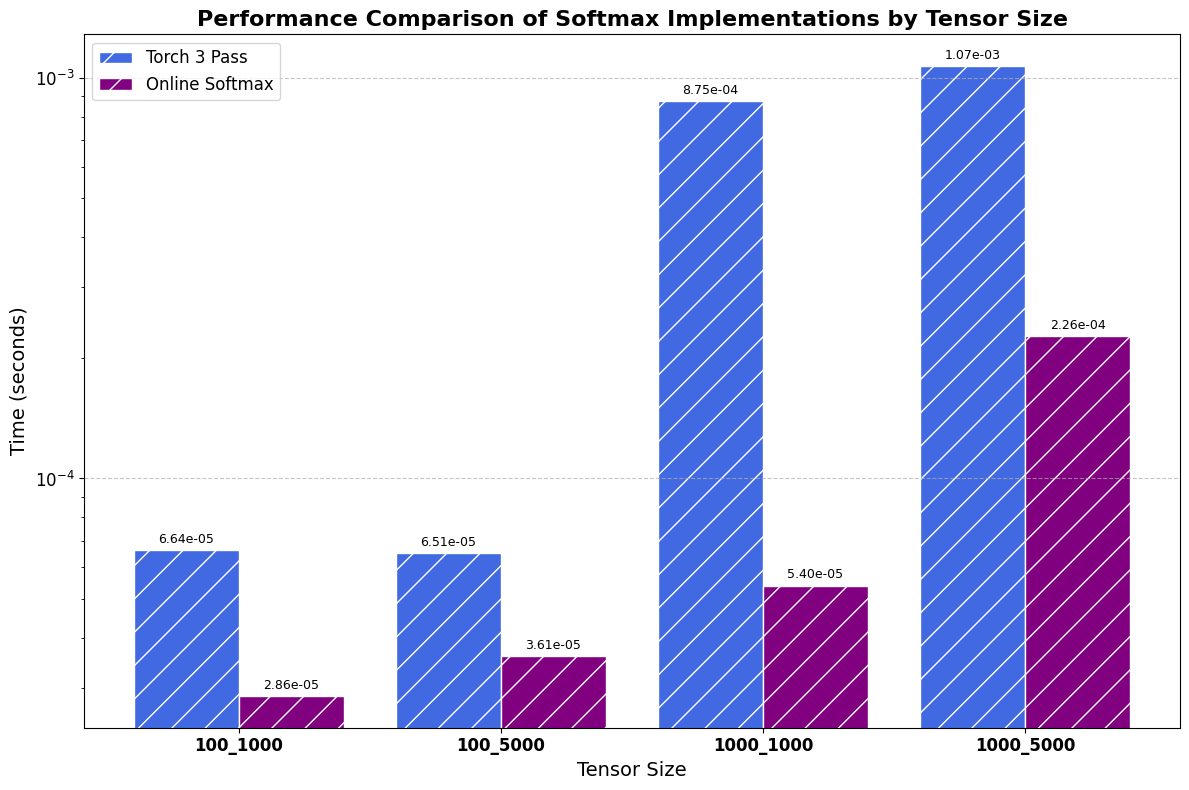

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Structured Data ---
# Data organized as before, mapping tensor size strings to a list of [Torch 3 Pass, Online Softmax] timings
data = averages_per_size

colors_for_methods = ['royalblue', 'purple'] # Colors for 'Torch 3 Pass' and 'Online Softmax'
method_labels = ['Torch 3 Pass', 'Online Softmax'] # Labels for the individual bars

tensor_sizes_labels = list(data.keys())
n_tensor_sizes = len(tensor_sizes_labels)
n_methods = len(method_labels) # 2 methods per tensor size

# --- 2. Automated Bar Positioning ---
# We'll group by tensor size, so each group will have 'n_methods' bars
group_width = 0.8 # Total width for a group of bars
bar_width = group_width / n_methods # Width of an individual bar

# Positions for the center of each group on the x-axis
group_x_positions = np.arange(n_tensor_sizes)

# --- 3. Plotting ---
fig, ax = plt.subplots(figsize=(12, 8))

# Loop through each method (Torch 3 Pass, Online Softmax)
for i, method_name in enumerate(method_labels):
    # Collect the timing for this specific method across all tensor sizes
    method_timings = [data[ts_label][i] for ts_label in tensor_sizes_labels]

    # Calculate the position for this method's bars within each group
    # Shift based on its index (i) relative to the group's center
    offset = (i - (n_methods - 1) / 2) * bar_width
    positions_for_method = group_x_positions + offset

    bars = ax.bar(positions_for_method, method_timings, bar_width,
                  label=method_name,
                  color=colors_for_methods[i],
                  hatch='/',
                  edgecolor='white')

    # Add text labels on top of each bar
    ax.bar_label(bars, fmt='%.2e', padding=3, fontsize=9, color='black')


# --- 4. Aesthetics and Labels ---
ax.set_xlabel("Tensor Size", fontsize=14)
ax.set_ylabel("Time (seconds)", fontsize=14)
ax.set_title("Performance Comparison of Softmax Implementations by Tensor Size", fontsize=16, fontweight="bold")

# Set x-axis ticks to be at the center of each group and label them with tensor sizes
ax.set_xticks(group_x_positions)
ax.set_xticklabels(tensor_sizes_labels, fontsize=12, fontweight="bold")
ax.tick_params(axis='y', labelsize=12)

# Set y-axis to logarithmic scale for better visualization
ax.set_yscale('log')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Improve legend and layout
ax.legend(loc="upper left", prop={'size': 12})
fig.tight_layout()

# Save and show the plot
plt.savefig("./test_grouped_by_tensor_size.png", dpi=300)
plt.show()